### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [25]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'data', 'ESC-10-depth')
samplerate = 44100

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.12.0
keras version = 2.10.0


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [2]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

In [3]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ 'Dense_AE_ffnn_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created 1Dim_Conv_AE_raw_flatten_count.txt with content '0' in folder Saved_Models
Created Dense_AE_ffnn_count.txt with content '0' in folder Saved_Models
Created AE_Conv_prep_flatten_count.txt with content '0' in folder Saved_Models
Created Fully_Convolutional_AE_count.txt with content '0' in folder Saved_Models


## 3.1 AE on raw audio - Dense FFNN

### Create the dataset

Note that we decided to normalize the data.

In [4]:
folder_number = 1
batch_size = 16  if not strong_pc else 128
preprocessing = None
start_time = time.time()
train, val, test, INPUT_DIM = create_US_dataset(
    preprocessing=preprocessing,
    folder_number=folder_number,
    batch_size=batch_size,
    main_dir = main_dir,
    ndim = 2,
)
print(f'This cell requires {round(time.time()-start_time,2)} seconds')

Creating the dataset from folder 01
Create the dataset with 2000 files requires 130.01 seconds.
This cell requires 130.07 seconds


Here we are using only dense layers, we use the Mean squared error as metric to measure the goodnees of the autoencoding.

We need to understand something about the mse: for now it is enoght to know on average which is the mse between two audio signals. In order to have a good estimate we took the mean mse over the first batch in the training set.

In [14]:
mse = tf.keras.losses.MeanSquaredError()
batch_mean_mse = 0

var_list=[]
# Extract the first batch from the training set: x is a tuple of arrays of dim (128,220500)
for x in train.take(1):
    batch_size = x[0].shape[0]
    for i in x[1]:
        for j in x[1]:
            #mse of i,j
            batch_mean_mse += mse(i, j).numpy()
            var_list.append(mse(i,j))
    break

batch_mean_mse /= batch_size**2

print(f'mean MSE between two random audio signals in the first batch: {batch_mean_mse:.5f}')
#mean MSE between two random audio signals in the first batch: 0.03532

print('The variance of the MSEs is {:.5f}'.format(np.var(var_list)))

mean MSE between two random audio signals in the first batch: 0.03553
The variance of the MSEs is 0.00132


### Preparation to use Keras-Tuner

Useful links:
- [Getting_started](https://keras.io/guides/keras_tuner/getting_started/)
- [Tailor_the_Search_Space](https://keras.io/guides/keras_tuner/tailor_the_search_space/)
- [Keras_Tuner_API](https://keras.io/api/keras_tuner/)

In [5]:
INPUT_DIM = (220500,1)
def build_autoencoder(INPUT_DIM = INPUT_DIM,
                      code_size = 32,
                      activation = 'tanh',
                      n_layers=1,
                      n_units_list=[128],
                      dropout=0.0,
                      batch_norm = True,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],):

    # INPUT: array_shape = shape of the single audio np array in the dataset: (220500,); code_size = number of neurons in the last dense layer of the encoder
    # OUTPUT: encoder and decoder models
    if n_layers is None:
        n_layers = len(n_units_list)

    # check if the n_units_list is coherent with n_layers
    if len(n_units_list) != n_layers:
        print('n_units_list must have the same length as n_layers!')
        n_layers = len(n_units_list)

    #check if the list is in decreasing order
    if n_units_list != sorted(n_units_list, reverse=True):
        print('The list of units must be in decreasing order!')
        n_units_list = sorted(n_units_list, reverse=True)

    # Encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(INPUT_DIM))
    encoder.add(layers.Flatten())

    for i in range(n_layers):
        encoder.add(layers.Dense(n_units_list[i], activation=activation))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if dropout>0:
            encoder.add(layers.Dropout(dropout))

    encoder.add(layers.Dense(code_size, activation=activation))

    # Decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input(code_size,))

    for i in range(n_layers):
        decoder.add(layers.Dense(n_units_list[-i-1], activation=activation))
        if batch_norm:
            decoder.add(layers.BatchNormalization())
        if dropout>0:
            decoder.add(layers.Dropout(dropout))

    decoder.add(layers.Dense(np.prod(INPUT_DIM)))
    decoder.add(layers.Reshape(INPUT_DIM))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = 'Autoencoder_ffnn')

    # compile the autoencoder
    lr = learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder

In [6]:
verbose = 2
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 2, n_units_list = [64,32])
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)


Model built with 28451252 trainable params
Model: "Autoencoder_ffnn"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_3 (InputLayer)                        [(None, 220500, 1)]                     0              
                                                                                                    
 sequential (Sequential)                     (None, 32)                              14115584       
                                                                                                    
 sequential_1 (Sequential)                   (None, 220500, 1)                       14336052       
                                                                                                    
Total params: 28,451,636
Trainable params: 28,451,252
Non-trainable params: 384
___________________________________________

In [7]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp, test = False):

    #define the hyperparameters
    if test:
        print('Running a smaller grid search as a test')
        code_size = hp.Choice(name = 'code_size', values=[32, 64])
        activation = 'tanh'
        n_layers = 1
        list_of_n_units_list = [[], [64]]
        n_units_list = list_of_n_units_list[hp.Int(name = 'n_units_list', min_value = 0, max_value = len(list_of_n_units_list)-1, step = 1, sampling = 'linear')]
        dropout = 0.0
        batch_norm = hp.Boolean('batch_norm', default=True)
        learning_rate = 1e-3
    else:
        code_size = hp.Choice(name = 'code_size', values = [8,16,32], default = 32)
        list_of_n_units_list = [[32], [32, 16], [64, 32, 16]]
        n_units_list = list_of_n_units_list[hp.Int(name = 'n_units_list', min_value = 0, max_value = len(list_of_n_units_list)-1, step = 1, sampling = 'linear')]
        n_layers = None
        activation = hp.Choice(name = 'activation', values = ['relu', 'tanh', 'elu'], default = 'tanh')
        dropout = hp.Choice(name = 'dropout', values = [0.0, 0.2, 0.5], default = 0.0)
        batch_norm = hp.Boolean('batch_norm', default=True)
        learning_rate = hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)

    #define the model
    model = build_autoencoder(n_units_list = n_units_list,
                              code_size = code_size,
                              activation = activation,
                              n_layers = n_layers,
                              dropout = dropout,
                              batch_norm = batch_norm,
                              learning_rate = learning_rate,
                              )

    return model




In [8]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 14334772 trainable params
Model: "Autoencoder_ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 220500, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32)                7057216   
                                                                 
 sequential_3 (Sequential)   (None, 220500, 1)         7277684   
                                                                 
Total params: 14,334,900
Trainable params: 14,334,772
Non-trainable params: 128
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [18]:
#dictionary with the default values of the hyperparams to be update each time
default_values = {
    'code_size' : 32,
    'activation' : 'tanh',
    'n_units_list' : 0, #0, 1 or 2 corresponding to the index of  [[32], [32, 16], [64, 32, 16]]
    'dropout' : 0.0,
    'batch_norm' : True,
    'learning_rate' : 1e-3,
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
max_model_size = 3*10**7 # only 10**7 exclude almost all the models
max_trials = 10
dir_name = os.path.join(main_dir,'Dense_AE_ffnn')
verbose=0

#define a smaller dataset for the grid search
if strong_pc:
    train_small = train
    val_small = val
else:       
    small_size_dataset = 400 
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(100).batch(25) 
    val_small = train_val_small.take(100).batch(25)
    
# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
} #we hope to have a decreasing list of numbers...

#to be consistent with this type of grid search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                value = default_values[fixed_param]
                if isinstance(value, list):
                    for idx, v in enumerate(value):
                        hp.Fixed(name=f"{fixed_param}_{idx}", value=v)
                else:
                    hp.Fixed(name=fixed_param, value=value)


        if verbose>1:
            display(hp.space)

        #create a tuner for the params not fixed
        tuner = build_tuner(build_model = build_model,
                            hpo_method = hpo_method,
                            max_model_size = max_model_size,
                            max_trials = max_trials,
                            dir_name = dir_name,
                            overwrite = True,
                            objective = kt.Objective('val_mse', direction='min'),
                            hp=hp,
                            not_fixed_param = hyper_params,
                            tune_new_entries=True
                            )

        if verbose>2:
            display(tuner.search_space_summary(extended = True))

        #fit the tuner
        epochs = 10 if not strong_pc else 50 #we can use a small number of epochs for the grid search
        patience = 10
        metrics = ['mse']
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                    verbose=verbose,
                                                    patience=patience)]

        tuner.search(train_small, validation_data = val_small,
                            callbacks=callbacks,
                            epochs=epochs,
                            verbose=int(verbose>0),
                    )

        #retrive the best value for the free hp
        best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

        #retrive the best score reached
        best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

        print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
        best_score_dict[hpo_method].append(best_score)

        #update the default dict of values
        default_values[hyper_params] = best_value

        #save the updated dictionary
        file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
        with open(file_path, 'wb') as file:
            pickle.dump(default_values, file)

        #delete the folder just created by the run
        shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))


    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)


#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores')
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)


Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 14334772 trainable params
Model built with 14334644 trainable params
Model built with 14334772 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 14334644 trainable params
16/16 [==============================] - 2s 39ms/step - loss: 0.0044 - mse: 0.0044
The best value for batch_norm is False, the best score is 0.004365806933492422


{'code_size': 32,
 'activation': 'tanh',
 'n_units_list': 0,
 'dropout': 0.0,
 'batch_norm': False,
 'learning_rate': 0.001}

Searching for the best value for code_size
Using Bayesian Optimization strategy for HPO
Model built with 14334644 trainable params
Model built with 14333604 trainable params
Model built with 14333084 trainable params
Model built with 14334644 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 14333604 trainable params
16/16 [==============================] - 2s 37ms/step - loss: 0.0044 - mse: 0.0044
The best value for code_size is 16, the best score is 0.004366470500826836


{'code_size': 16,
 'activation': 'tanh',
 'n_units_list': 0,
 'dropout': 0.0,
 'batch_norm': False,
 'learning_rate': 0.001}

Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 14333604 trainable params
Model built with 14333604 trainable params
Model built with 14333604 trainable params
Model built with 14333604 trainable params
INFO:tensorflow:Oracle triggered exit
Model built with 14333604 trainable params
16/16 [==============================] - 2s 34ms/step - loss: 0.0044 - mse: 0.0044
The best value for activation is relu, the best score is 0.004363660700619221


{'code_size': 16,
 'activation': 'relu',
 'n_units_list': 0,
 'dropout': 0.0,
 'batch_norm': False,
 'learning_rate': 0.001}

{'RandomSearch': [0.004365806933492422],
 'BayesianOptimization': [0.004366470500826836],
 'Hyperband': [0.004363660700619221]}

In [14]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

code_size activation  n_units_list  dropout  batch_norm  \
RandomSearch                 32       tanh             0      0.0        True   
BayesianOptimization         32        elu             0      0.0        True   
Hyperband                    32        elu             0      0.0        True   

                      learning_rate  
RandomSearch               0.001000  
BayesianOptimization       0.001000  
Hyperband                  0.000163

### Train the model with the best params on more data

n_units_list must have the same length as n_layers!
Model built with 14333884 trainable params
Model: "Autoencoder_ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 220500, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 8)                 7056696   
                                                                 
 sequential_3 (Sequential)   (None, 220500, 1)         7277188   
                                                                 
Total params: 14,333,884
Trainable params: 14,333,884
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0
Creating the dataset from folder 01
Create the dataset with 2000 files requires 100.69 seconds.
INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_M

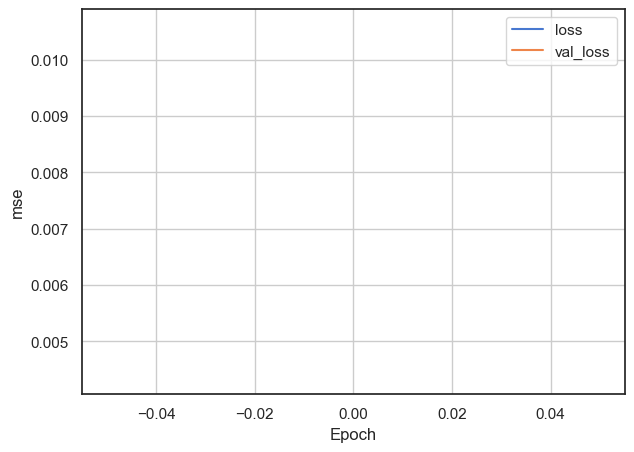

2/2 [==============================] - 33s 15s/step - loss: 0.0056 - mse: 0.0056


[0.00558775570243597, 0.00558775570243597]

This model has a size of 164.0899658203125 MB
Creating the dataset from folder 02
Create the dataset with 2000 files requires 1100.83 seconds.
INFO:tensorflow:Assets written to: g:\My Drive\Human_Data_Analytics_Project_2023\Saved_Models\Dense_AE_ffnn\assets
Best epoch: 1


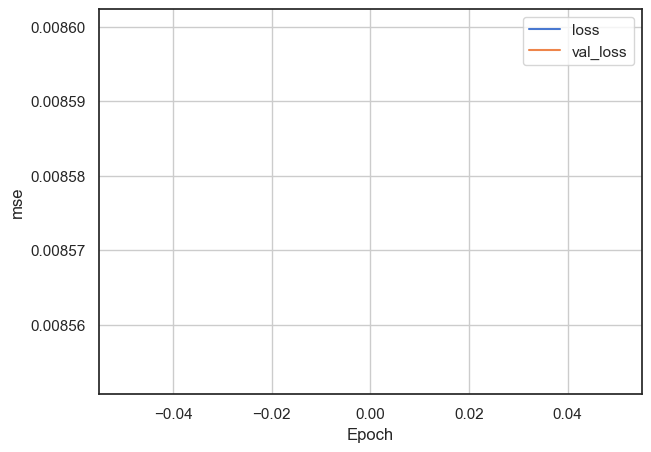

2/2 [==============================] - 27s 13s/step - loss: 0.0086 - mse: 0.0086


[0.008558142930269241, 0.008558142930269241]

This model has a size of 164.0899658203125 MB


In [16]:
best_params = {
    'n_units_list':[32, 16],
    'code_size': 8,
    'activation':'tanh',
    'dropout':0.5,
    'batch_norm':False,
    'learning_rate':0.019076,
}

# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already quite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()
epochs = 1 if not strong_pc else 100
n_folders = 2 if not strong_pc else 10 #then you can restart and train on more folders
autoencoder = US_training(AE_name = 'Dense_AE_ffnn', autoencoder = autoencoder, epochs = epochs  , n_folders = n_folders)

### Show the reconstruction capabilities of the model

Model: "Autoencoder_ffnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 220500, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 8)                 7056696   
                                                                 
 sequential_3 (Sequential)   (None, 220500, 1)         7277188   
                                                                 
Total params: 14,333,884
Trainable params: 14,333,884
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 86ms/step


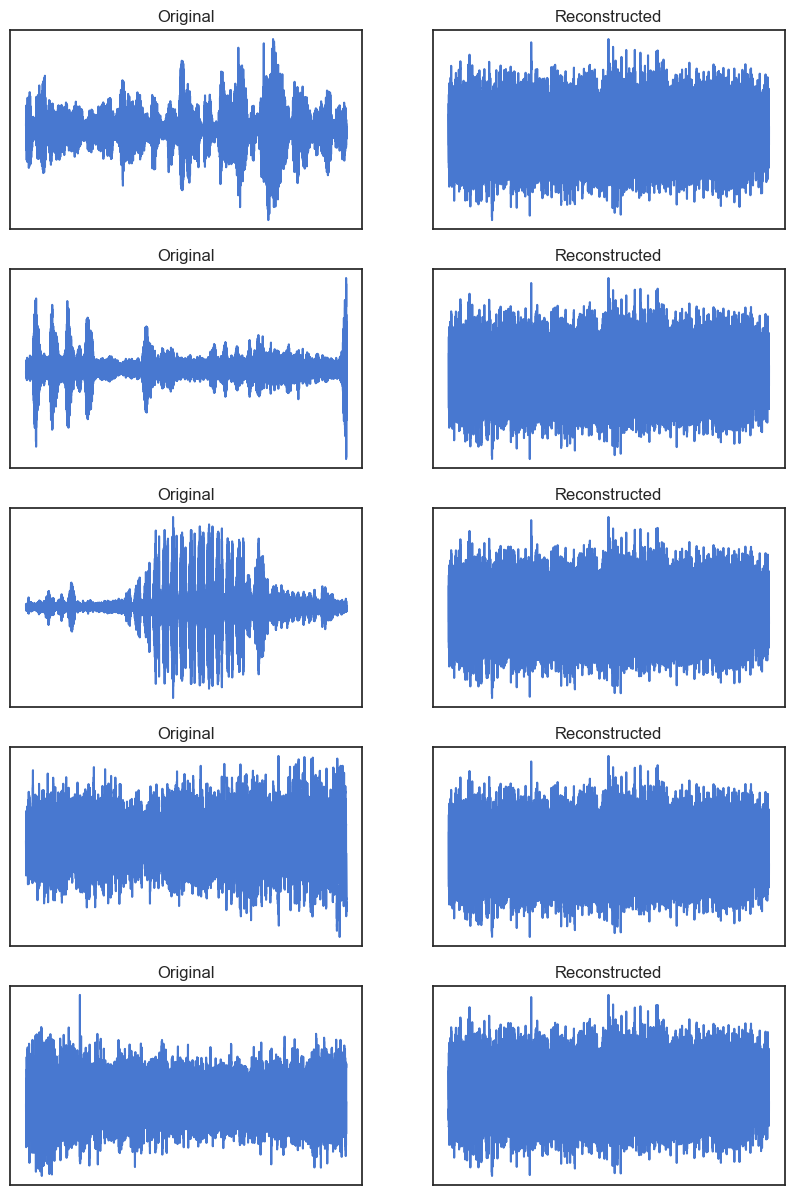

In [17]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models','Dense_AE_ffnn'))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed_raw(model = model_loaded, n_figures = 5, test=test)